In [13]:
import sys
sys.path.insert(0,'../..')
from prior_ratio import GaussianChieffToIASPriorRatio, FiducialModelPriortoIASPriorRatio, \
                                IASPriortoInjectionPriorRatio
from population_likelihood import PopulationLikelihood
from cogwheel.prior import Prior, UniformPriorMixin, IdentityTransformMixin
import cogwheel.sampling as sampling

In [18]:
import pandas as pd
import glob
import numpy as np
import corner

In [3]:
from cogwheel.posterior import Posterior

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal
lal.swig_redirect_standard_output_error(False)

/home/isha/PopulationSelectionEffects/cogwheel_population_inference/cogwheel/cogwheel/new_population_inference/../../cogwheel/waveform.py:6: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal


True

## Create Likelihood Object

In [4]:
# Create PriorRatio objects
pop_to_ias = GaussianChieffToIASPriorRatio()
ffid_to_ias = FiducialModelPriortoIASPriorRatio()
ias_to_injprior = IASPriortoInjectionPriorRatio()

In [5]:
# read the pe_samples, injections_summary from file
pe_samples_root = '../population_inference/data/PE_samples10'
pe_samples_fnames = glob.glob(pe_samples_root+'/*')
pe_samples=[]
for fname in pe_samples_fnames:
    pe_samples.append(pd.read_feather(fname))
recovered_injections_df = pd.read_pickle('../population_inference/data/injections_summary.pkl')
injections_summary_dict = {'Ninj':20000, 'recovered_injections':recovered_injections_df}

In [6]:
pastro_ref = np.ones(10)
rate0=90

In [7]:
likelihood_obj = PopulationLikelihood(pop_to_ias, ffid_to_ias, ias_to_injprior, pe_samples, pastro_ref, 
                                 injections_summary_dict, rate0)

In [8]:
hyperparams_dic = {'rate':50, 'chieff_mean':0, 'chieff_std':0.4}
likelihood_obj.lnlike(hyperparams_dic)

-567406.0990508045

## Create prior object

In [9]:
class GaussianChieffHyperPrior(IdentityTransformMixin, UniformPriorMixin, Prior):
    standard_params = ['rate','chieff_mean', 'chieff_sigma']
    range_dic={'rate':(10, 1000),'chieff_mean':(-1, 1), 'chieff_std':(0.1,2)}

In [10]:
gaussianchieffprior = GaussianChieffHyperPrior()

## Create posterior and sample

In [15]:
post = Posterior(gaussianchieffprior, likelihood_obj)

In [16]:
output_file_path = '/home/isha/PopulationSelectionEffects/output/new_pop_inf'
pym = sampling.PyMultiNest(post)
pym.run_kwargs = {'n_iter_before_update': 1000,'n_live_points': 256,'evidence_tolerance': 0.25}
# perform the pe now
pym.run(output_file_path)

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  256
 dimensionality =    3
 *****************************************************

 MultiNest Warning!
 Parameter            1  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            1  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            1  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            1  of mode            1  is converging towards the edge of the prior.
 Parameter            3  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            1  of mode            1  is converging towards the edge of the prior.
 Parameter            3  of mode            1

In [17]:
samples = pd.read_feather(output_file_path+'/samples.feather')

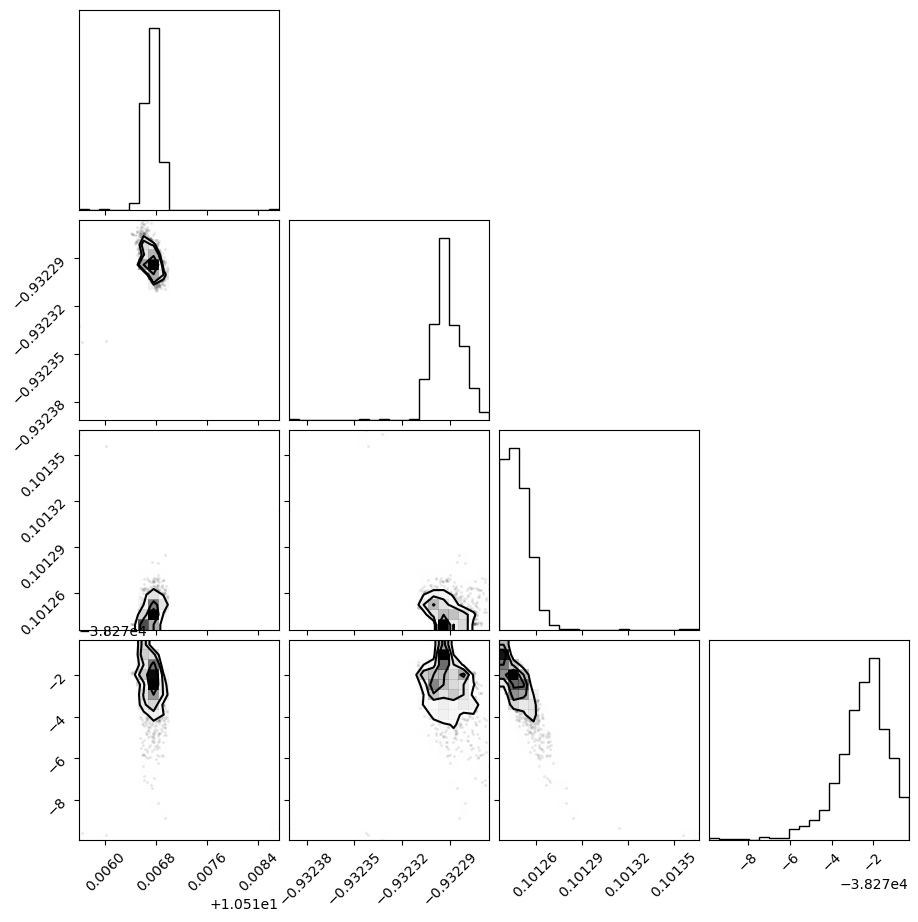

In [20]:
corner.corner(samples);